# 🪐 Image Processing with the Thunderbird South Telescope 📸
##### CCD Image Calibration and Color Reconstruction

## Solutions

---

## Objective

In this workshop, you will explore how astronomers process raw telescope data to produce clean, calibrated, and scientifically useful images.

By the end of this session, you will:

- Understand what a **CCD detector** is and how it captures starlight.
- Learn about **dark**, and **flat** frames and why we use them.
- Calibrate a real **science image** to remove unwanted artifacts.
- Create a **greyscale image** that accurately represents true sky brightness.
- Combine filtered images to form a **color composite** of an astronomical object.


> **Before you proceed, save a copy in your drive. DO NOT edit this notebook.**

---

## Background: How Telescopes Capture Light

Every telescope equipped with a **CCD (Charge-Coupled Device)** camera collects photons from space and converts them into an electronic signal.  
Each pixel on the CCD measures how many photons it received — producing a 2D image where pixel values correspond to light intensity.

However, these raw images are *not* clean.  
They contain noise and irregularities from the camera electronics, thermal effects, and optical system.  
If left uncorrected, these can distort brightness measurements and image quality.

To fix this, astronomers take **calibration frames** to measure and remove these imperfections.


---
## Code: Setting Up Your Environment

Now that you understand how we collect data and how to correct it, it's time to use real data and create images of your own!

But first, we need to ensure the correct coding environment.

Run the code cells below by pressing **shift + enter**

In [1]:
# File path setup to import files directly from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## CHANGE PATH
path = "/content/drive/MyDrive/Colab Notebooks/workshop2/M8_data"
import sys
import os

sys.path.append(path)
os.chdir(path)

In [3]:
# Ensure all required data is present in your folder
!pwd
!ls

/content/drive/.shortcut-targets-by-id/1TjHLIM8j1vg5vW6IPNOM4OQ2Lp4g8H2P/M8_data
10s_DarksForFlats    calibrated_V_frames   master_flat_B.fits
60s_DarksForImage    combined_BVR.fits	   master_flat_R.fits
B		     Flat_B		   master_flat_V.fits
calibrated_B.fits    Flat_R		   R
calibrated_B_frames  Flat_V		   uncalibrated_V.fits
calibrated_R.fits    M8_RGB.png		   V
calibrated_R_frames  master_dark_10s.fits
calibrated_V.fits    master_dark_60s.fits


In [4]:
%pip install ccdproc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.3/351.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.2/195.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.8/378.8 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 117.9 MB/s eta 0:00:00
  Created wheel for pims: filename=PIMS-0.7-py3-none-any.whl size=84590 sha256=8bcd92a8f0c2446344b9bb316dc3f76e85e99b5f1102edafc3dd0dfc7ba7c52a
  Stored in directory: /root/.cache/pip/wheels/be/9c/72/7cb84823aaa980c2e44064caae0ba869239270fac14f7

We will use exisiting Python libraries to perform our image processing.

##### 1. <u> Astropy </u>
The **Astropy** library is the foundation of Python-based astronomy.

**In this workshop, we use:**
- `astropy.io.fits` → to read and write FITS image files.  
- `astropy.visualization` → to automatically scale brightness and contrast (like DS9's Z-Scale).  
- `astropy.nddata.CCDData` → a special data object that stores both image data *and* metadata (exposure time, units, etc.).
- `astropy.units` → a set of defined units recognised by the astropy library.


##### 2. <u> CCDProc </u>
The **ccdproc** package (short for *CCD processing*) is built on Astropy and automates the most common CCD calibration steps used by professional astronomers.

**We use it to:**
- Combine multiple images into a **master frame** (e.g., median combine bias or dark frames).  
- Apply calibration steps like:
  - `subtract_bias()` - removes the constant electronic offset.  
  - `subtract_dark()` - removes thermal current noise.  
  - `flat_correct()` -  divides by a normalized flat field to correct uneven illumination.  

##### 3. <u> NumPy </u>
**NumPy** is Python's numerical engine.  
It allows us to treat images as 2-D arrays of numbers and perform fast mathematical operations on all pixels at once.

**We use it for:**
- Calculating statistics (like the mean of a flat frame).  
- Performing arithmetic operations between images.  
- Efficiently manipulating pixel data during normalization.


##### <u> 4. Matplotlib </u>
**Matplotlib** is Python's main plotting and visualization library.

**We use it to:**
- Display images using `imshow()` in greyscale or color.  

##### <u> 5. Glob and OS </u>
These two standard Python libraries help us manage files.

**`glob`** finds all files in a folder matching a pattern (for example, `*.fits`).  
**`os`** handles paths and file system operations.

We use them to automatically load all the calibration and science images from their respective folders.

In [5]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy import units as u
import ccdproc
import glob
import os

## Part 1: Calibration and Greyscale Image
Load and calibrate your raw science image using dark and flat frames.

---

### <u>Load Calibration and Science Data</u>


In [6]:
# darks
darks_for_images = glob.glob('60s_DarksForImage/M8_D_*.fits')
darks_for_flats = glob.glob('10s_DarksForFlats/dark10s_*.fits')
# flats
flat_files_V = glob.glob('Flat_V/flatV_*.fits')
# science images
V_files    = glob.glob('V/M8_V_*.fits')

### Why Calibrate?

Every CCD camera — whether on a research telescope or a DSLR — introduces small but predictable errors into every image.  
These errors come from the **electronics**, the **temperature of the detector**, and the **optical setup** (lenses, mirrors, filters, dust, etc.).  
To remove them, astronomers take special images called **calibration frames**.  

Let's look at each one in detail:

#### <u> 1. Dark Frames — Measuring Thermal Noise</u>

Even in complete darkness, CCDs generate electrons when they get warm.  
This **dark current** builds up over time and makes pixels appear brighter than they should.

- **How it's taken:**  
  With the **shutter closed** and the **same exposure time** and **temperature** as your science images.  
  For example, if your science exposure is 60 seconds, you take 60-second darks.

- **What it corrects:**  
  The extra brightness caused by heat (dark current).  
  Removing it prevents false “stars” from appearing where no light actually hit the CCD.

#### <u> 2. Flat Frames — Measuring Uneven Illumination </u>

No optical system is perfect — dust on lenses, uneven lighting, or vignetting (edge darkening) can make some parts of your image appear dimmer than others.  
Each pixel also responds slightly differently to incoming light.  
A **flat field** measures these variations.

- **How it's taken:**  
  With the telescope pointed at a **uniform light source**, like the twilight sky, a dome screen, or a flat-field panel.  
  Exposure time is short, but bright enough to fill most of the detector's dynamic range.

- **What it corrects:**  
  Pixel-to-pixel sensitivity variations and optical vignetting.  
  When you divide your science frame by this, every pixel represents the *same* physical light intensity.

#### <u> 3. Science Frames — The Actual Astronomical Image </u>

These are the exposures of your target object — a nebula, galaxy, planet, or star field.  
They contain both the true celestial signal and all the unwanted noise from the effects above.

By carefully subtracting bias and dark current, and dividing by the flat field,  
we recover the **true photon counts** from the sky — what astronomers use to measure brightness, color, and structure.


---

## The Calibration Frames

The table below summarizes the purpose of each calibration from and how it is used.
| Frame Type | What It Measures | How It's Used |
|-------------|------------------|----------------|
| **Dark Frame** | Thermal noise (builds with exposure time) | Subtracted after bias |
| **Flat Frame** | Uneven illumination and pixel sensitivity | Used to divide and equalize the field |
| **Science Frame** | The actual astronomical exposure | Calibrated to show true object brightness |


### <u>Create Master Dark</u>

We have two sets of dark frames with different exposure times: 10s and 60s. The choice of which dark frame to use for calibration depends on the exposure time of the image being corrected.

In our case:

*   The **10s dark frame** will be used to calibrate the **flat frames**.
*   The **60s dark frame** will be used to calibrate the **science images**.


In [9]:
# Exercise: Create the Master Dark Frame for Flats
# --------------------------------------------------
# Dark frames measure the thermal noise in your CCD sensor.
# Combine them to create a single "master dark" that represents this noise pattern.
# Replace the Nones below with your code

# TODO:
# 1. Read all dark frame files into CCDData objects
# 2. Combine them into one master dark using ccdproc.combine()

flat_dark_list = [CCDData.read(f, unit='adu') for f in darks_for_flats]
master_flat_dark = ccdproc.combine(flat_dark_list, method='median', sigma_clip=True, sigma_clip_low_thresh=3,
                                   sigma_clip_high_thresh=3, sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)
master_flat_dark.write('master_dark_10s.fits', overwrite=True)

<details>
<summary>💡 Hint 1</summary>

Each .fits file in darks_for_images contains one dark exposure.
You can read them into memory using `CCDData.read()`, which loads the image and its header information.
The unit='adu' tells Astropy the brightness unit of the pixel values (Analog-to-Digital Units).
Use a For loop to load everything from darks_for_images

</details>

<details>
<summary>💡 Hint 2</summary>

Now that you've read the frames, combine them into a single image using `ccdproc.combine()`.
- method='median' removes random noise, and enabling
- sigma_clip=True removes unusually bright pixels (like cosmic rays).
- sigma_clip_low_thresh=3,
- sigma_clip_high_thresh=3,
- sigma_clip_func=np.ma.median,
- sigma_clip_dev_func=mad_std

</details>

In [10]:
# Exercise: Create the Master Dark Frame for Science Frames
# --------------------------------------------------
# Similar to your code above, combine the darks to create a single
# "master dark" that represents this noise pattern.
# Replace the Nones below with your code

# TODO:
# 1. Read all dark frame files into CCDData objects
# 2. Combine them into one master dark using ccdproc.combine()
dark_list = [CCDData.read(f, unit='adu') for f in darks_for_images]
master_dark = ccdproc.combine(dark_list, method='median', sigma_clip=True, sigma_clip_low_thresh=3,
                                   sigma_clip_high_thresh=3, sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)
master_flat_dark.write('master_dark_10s.fits', overwrite=True)
master_dark.write('master_dark_60s.fits', overwrite=True)

### <u>Create Master Flat (V)</u>

In [11]:
# Exercise: Create the Master Flat Frame
# --------------------------------------------------
# Flat frames measure uneven illumination and pixel sensitivity differences
# in your telescope’s detector. These correct for dust, vignetting, and
# other variations in brightness across the field of view.
# Replace the Nones below with your code

# TODO:
# 1. Read all flat frame FITS files into CCDData objects
# 2. Subtract the master dark for flats from each flat frame
# 3. Combine the corrected flats into a single master flat using sigma clipping
# 4. Normalize your master flat and save it as 'master_flat_V.fits'

# Read flat files
flat_list_V = [CCDData.read(f, unit='adu') for f in flat_files_V]

# Subtract 10s master dark frame
flat_corr_V = [ccdproc.subtract_dark(f,
                                     master_flat_dark,
                                     exposure_time='EXPTIME',
                                     exposure_unit=u.second,
                                     scale = False
                                     ) for f in flat_list_V]

# Combine and normalize
master_flat_V = ccdproc.combine(flat_corr_V, method='median', sigma_clip=True, sigma_clip_low_thresh=3,
                                sigma_clip_high_thresh=5, sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)
master_flat_V = master_flat_V.divide(np.median(master_flat_V.data))
master_flat_V.write('master_flat_V.fits', overwrite=True)

<details>
<summary>💡 Hint 1</summary>

Similar to Your code above, read flat_files_V into flat_list_V

# </details>

<details>
<summary>💡 Hint 2</summary>

Your flat frames contain both illumination patterns and the dark current (thermal noise).
You need to remove the dark component first using ccdproc.`subtract_dark()` using:
- exposure_time='EXPTIME'
- exposure_unit=u.second
- scale = False

use a for loop to do this for each fit in flat_list_V

</details>

<details>
<summary>💡 Hint 3</summary>

After dark subtraction, combine all your corrected flats into one Master Flat similar to how you combined darks in your code above

</details>

<details>
<summary>💡 Hint 4</summary>

Dividing by the median value ensures the flat's average brightness is 1. So it doesn't change the overall exposure when applied to your science images.
You can calculate the median using `np.median()` for `master_flat_V.data`.
divide used `master_flat_V.divide()`

</details>

### Visualizing the Noise
Lets take a look at what only the noise in the image looks like:


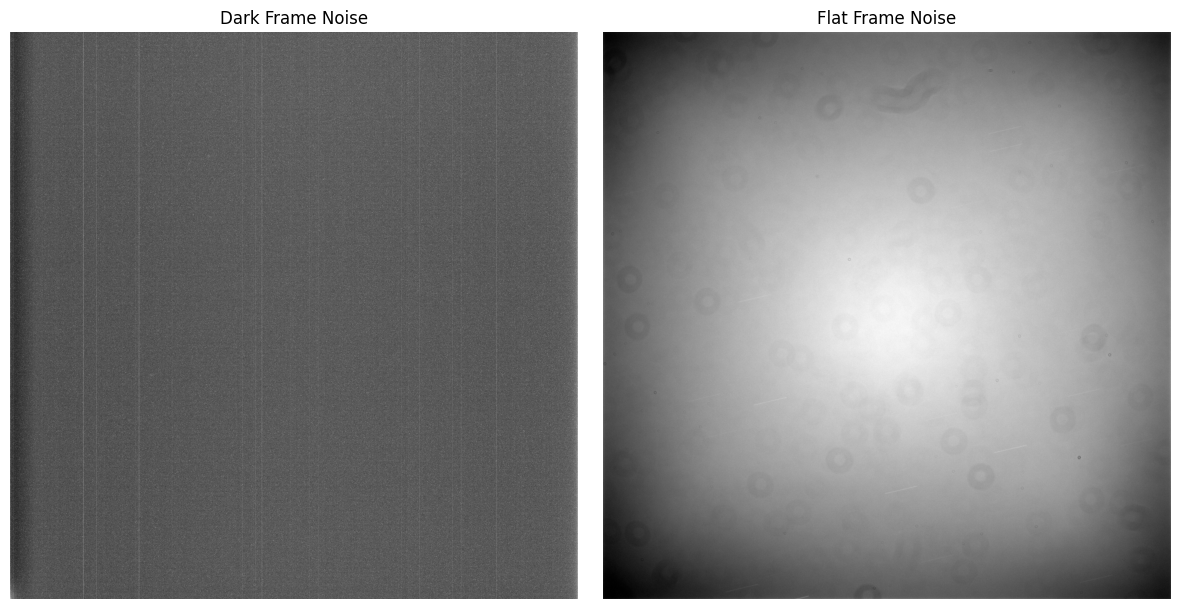

In [12]:
norm_dark = ImageNormalize(master_dark, interval=ZScaleInterval())
norm_flat = ImageNormalize(master_flat_V, interval=ZScaleInterval())
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(master_dark, cmap='gray', origin='lower', norm= norm_dark)
axes[0].set_title("Dark Frame Noise")
axes[0].axis('off')

axes[1].imshow(master_flat_V, cmap='gray', origin='lower', norm= norm_flat)
axes[1].set_title("Flat Frame Noise")
axes[1].axis('off')

plt.tight_layout()
plt.show()

---

### The Calibration Process

1. **Subtract the Master Dark (60s Exposure)**  
   Removes the thermally generated electrons that accumulate during the exposure.  
   Dark current depends on exposure time and temperature.

2. **Divide by the Master Flat**  
   Corrects for uneven illumination and sensitivity across the CCD surface.  
   Normalized so it doesn't alter overall brightness, only relative variations.

The calibrated image now represents true sky intensity across all pixels.

Below is an example of a function: sections of repeatable code that you can call with a single line of code. This is useful when you have long streches of code that is used a lot.

**You will help implement parts of the function below**

Note: This is just for your understanding and you won't actually need to complete this code to continue to the next section, but it is highly recommended

In [24]:
# Exercise: Calibrate Science Frames
# --------------------------------------------------
# Each science frame contains both your actual image data (the light from your object)
# and unwanted signals like dark current(dark frame) and uneven illumination(flat frame).
# In this step, you’ll use the master dark and master flat frames you created earlier
# to correct your raw science data.
# Replace the Nones below with your code

# TODO:
# 1. Read each science frame as a CCDData object
# 2. Subtract the master dark to remove thermal noise
# 3. Apply flat correction to correct for uneven pixel sensitivity

def calibration_pipline(data, master_dark, master_flat, output_dir, prefix):
  """
  calibrate all science frames for a given filter.

  Parameters
  ----------
  file_list : list
      List of FITS file paths to calibrate.
  master_dark : CCDData
      Master dark frame (CCDData object).
  master_flat : CCDData
      Master flat frame (CCDData object).
  output_dir : str
      Directory to save calibrated frames.
  prefix : str
      Prefix for naming the calibrated FITS files.
  """
  os.makedirs(output_dir, exist_ok=True)
  l = len(data)

  # Read in science frames
  for i, f in enumerate(data):
    print(f"Processing frame {i+1}/{l}: {f}")

    sci = CCDData.read(f, unit='adu')

    # Subtract dark
    sci_corr = ccdproc.subtract_dark(
      sci,
      master_dark,
      exposure_time='EXPTIME',
      exposure_unit=u.second
    )

    # Apply flat correction
    sci_corr = ccdproc.flat_correct(sci_corr, master_flat)

    # Save calibrated frame
    output_name = os.path.join(output_dir, f"{prefix}_{i:03d}.fits")
    sci_corr.write(output_name, overwrite=True)

    # Free memory before next loop
    del sci, sci_corr

  print(f"{l} frames calibrated and saved in {output_dir}")

<details>
<summary>💡 Hint 1</summary>

Keep in mind that the code you are writing is within a for loop already. You want to read all the files (f) into `sci` like in your code above

# </details>

<details>
<summary>💡 Hint 2</summary>

Your science frames contain both illumination patterns and the dark current (thermal noise).
Similar to how you subtracted the darks from the flats, use  `ccdproc.subtract_dark()` to subtract the **Correct Dark Frame**

</details>

<details>
<summary>💡 Hint 3</summary>

After dark subtraction, your image still has uneven brightness across the field
caused by variations in the detector or telescope optics. Use your master flat
to correct this pattern so all parts of the image have the same sensitivity.
Use `ccdproc.flat_correct()` on sci_corr, and master_flat

</details>

In [25]:
def combine_frames(calibrated_files, output_name):
  """
  combines the calibrated frames into a single image
  """
  l = len(calibrated_files)
  # Initialize accumulation variables
  sum_image = None
  count = 0

  for i, f in enumerate(calibrated_files):
    data = fits.getdata(f).astype(np.float32)  # ensure numeric

    if sum_image is None:
      sum_image = np.zeros_like(data)

    sum_image += data
    count += 1

    if (i + 1) % 10 == 0 or (i + 1) == l:
      print(f"Added {i+1}/{l} frames")

  # Compute average on the fly
  stacked = sum_image / count
  fits.writeto(output_name, stacked, overwrite=True)

### Note: You are working with a lot of science frames. **The following code will take a while to run**

The code below runs the calibration_pipeline function, that you wrote above, and combine_frames function on the V-Science frames. The result of running the code below has already been precomputed and stored in the data.

**You can proceed without running the following code**

The code is here for your understanding and you can choose to uncomment it, run the code and experiment with it.

In [26]:
calibration_pipline(V_files, master_dark, master_flat_V, 'calibrated_V_frames', 'calibrated_V')

Processing frame 1/70: V/M8_V_079_2025_00002-28054.fits


/usr/local/lib/python3.12/dist-packages/astropy/units/quantity.py:653: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.12/dist-packages/astropy/nddata/nduncertainty.py:877: RuntimeWarning: invalid value encountered in divide
  (left + right + correlation_sign * corr)


Processing frame 2/70: V/M8_V_079_2025_00002-28055.fits
Processing frame 3/70: V/M8_V_079_2025_00002-28056.fits
Processing frame 4/70: V/M8_V_079_2025_00002-28057.fits
Processing frame 5/70: V/M8_V_079_2025_00002-28058.fits
Processing frame 6/70: V/M8_V_079_2025_00002-28059.fits
Processing frame 7/70: V/M8_V_079_2025_00002-28060.fits
Processing frame 8/70: V/M8_V_079_2025_00002-28061.fits
Processing frame 9/70: V/M8_V_079_2025_00002-28062.fits
Processing frame 10/70: V/M8_V_079_2025_00002-28063.fits
Processing frame 11/70: V/M8_V_079_2025_00002-28064.fits
Processing frame 12/70: V/M8_V_079_2025_00002-28065.fits
Processing frame 13/70: V/M8_V_079_2025_00002-28066.fits
Processing frame 14/70: V/M8_V_079_2025_00002-28067.fits
Processing frame 15/70: V/M8_V_079_2025_00002-28068.fits
Processing frame 16/70: V/M8_V_079_2025_00002-28069.fits
Processing frame 17/70: V/M8_V_079_2025_00002-28070.fits
Processing frame 18/70: V/M8_V_079_2025_00002-28071.fits
Processing frame 19/70: V/M8_V_079_2025

In [27]:
calibrated_files = sorted(glob.glob('calibrated_V_frames/calibrated_V_*.fits'))
combine_frames(calibrated_files, 'calibrated_V.fits')

Added 10/70 frames
Added 20/70 frames
Added 30/70 frames
Added 40/70 frames
Added 50/70 frames
Added 60/70 frames
Added 70/70 frames


### Display Calibrated Greyscale Image

The code below helps you visualize the calibrated data

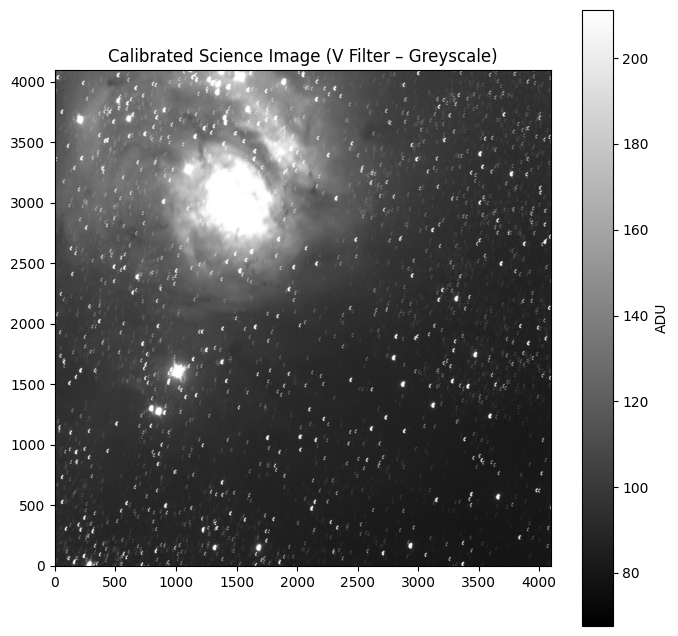

In [13]:
data_V = fits.getdata('calibrated_V.fits')
norm = ImageNormalize(data_V, interval=ZScaleInterval())

plt.figure(figsize=(8,8))
plt.imshow(data_V, cmap='gray', origin='lower', norm=norm)
plt.title("Calibrated Science Image (V Filter – Greyscale)")
plt.colorbar(label='ADU')
plt.show()

---


## Part 2: Color Image Reconstruction
### Background
Astronomers capture separate exposures of the same target through different filters.
Each filter image is individually calibrated and then merged into a color composite.

---

## From Calibration to Color

Astronomical CCDs record **intensity**, not color.  

To create color images, astronomers take **separate exposures through different filters**, each one isolating a portion of the light spectrum, letting us study how brightness changes with wavelength.

When these three images are calibrated and combined, we get a color composite that approximates what the human eye might see — or a **false-color** image that highlights specific features like gas, dust, or temperature differences.


In [14]:
# Read calibrated FITS data
R = fits.getdata('calibrated_R.fits')
V = fits.getdata('calibrated_V.fits')
B = fits.getdata('calibrated_B.fits')

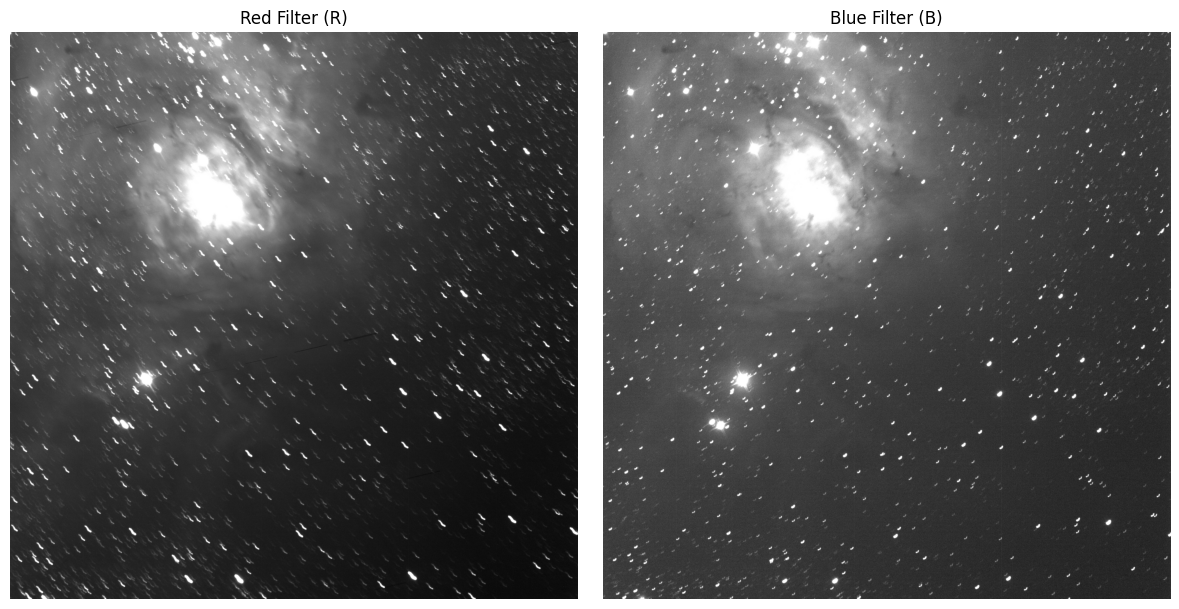

In [15]:
# Display result of blue and red filters
norm_R = ImageNormalize(R, interval=ZScaleInterval())
norm_B = ImageNormalize(B, interval=ZScaleInterval())
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(R, cmap='gray', origin='lower', norm= norm_R)
axes[0].set_title("Red Filter (R)")
axes[0].axis('off')

axes[1].imshow(B, cmap='gray', origin='lower', norm= norm_B)
axes[1].set_title("Blue Filter (B)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [16]:
def clean(img):
    img = np.nan_to_num(img, nan=0.0)
    lo, hi = np.percentile(img, (0.5, 99.5))
    img = np.clip((img - lo) / (hi - lo), 0, 1)
    return img

R = clean(R)
V = clean(V)
B = clean(B)

Images are composed of pixels and each pixel has three values: Red(R), Green(G), and Blue(B). Since we have values for what the red, green, and blue values for each point in the image, we can stack them onto each other to create a colored composite.

For this to work, the images need to match up properly. As you can see from the potted images of the red and blue filtered images, they are different from your initial image, and hence don't line up properly.

The code cell below shifts the red and blue images in the x and y direction. You can experiment with this to see what gives you the best looking image

In [21]:
from scipy.ndimage import shift
# change the pixel values below by small amounts to see what works best
# _r is for the red image
# _b is for the blue image

x_r = 20
y_r = 40
x_b = 10
y_b = 10

R_shifted = shift(R, shift=(x_r, y_r))
B_shifted = shift(B, shift=(x_b, y_b))

In [22]:
# Exercise: Create a Color Composite Image
# --------------------------------------------------
# You now have three calibrated images: one through each of the Red (R),
# Visual (V), and Blue (B) filters.
# By stacking these three grayscale images together, you can create a
# full-color representation of your object.
# Replace the Nones below with your code


# TODO:
# 1. Combine your Red, V (green), and Blue images into a single RGB array
# 2. if you applied a shift, use the correct R and B values

rgb_aligned = np.dstack((R_shifted, V, B_shifted))
rgb_aligned = np.clip(rgb_aligned, 0, 1)

<details>
<summary>💡 Hint 1</summary>

Each of your calibrated filter images represents one color channel:

R -> Red

V -> Green

B -> Blue

You can combine them into a single color image by stacking them along a new dimension using `np.dstack()`.

Think of this like layering three grayscale images - one for each color - to make an RGB photograph.

</details>

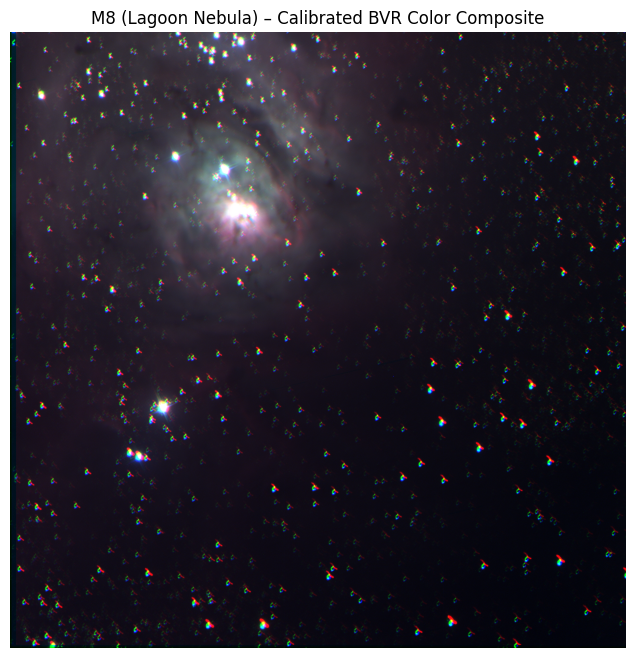

In [23]:
# Display
plt.figure(figsize=(8,8))
plt.imshow(rgb_aligned, origin='lower')
plt.axis('off')
#plt.savefig('M8_RGB.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.title("M8 (Lagoon Nebula) – Calibrated BVR Color Composite")
plt.show()